# Project: Credit Card Customer Segmentation

## Problem Statement
AllLife Bank wants to focus on its credit card customer base in the next financial year. They have been advised by their marketing research team, that the penetration in the market can be improved. Based on this input, the Marketing team proposes to run personalized campaigns to target new customers as well as upsell to existing customers. Another insight from the market research was that the customers perceive the support services of the bank poorly. Based on this, the Operations team wants to upgrade the service delivery model, to ensure that customers queries are resolved faster. Head of Marketing and Head of Delivery both decide to reach out to the Data Science team for help.

## Objective
To identify different segments in the existing customer based on their spending patterns as well as past interaction with the bank.

## Key Questions
1. How many different segments of customers are there?
2. How are these segments different from each other?
3. What are your recommendations to the bank on how to better market to and service these customers?

## <a id = "TOC"></a> Table of Contents
- <a href = #import>Import Libraries and Load Dataset </a>

- <a href = #eda>EDA</a> 
    - <a href = #univariate>Univariate Analysis</a>
    - <a href = #bivariate>Bivariate Analysis</a>
    - <a href = #eda-insights>Summary EDA Insights</a>
- <a href = #k-means>K-Means Clustering</a>
- <a href = #hierarchical>Hierarchical Clustering</a> 
- <a href = #conclusion>Conclusion and Business Recommendations</a>

## Data Description
Data is of various customers of a bank with their credit limit, the total number of credit cards the customer has, and different channels through which customer has contacted the bank for any queries, different channels include visiting the bank, online and through a call.

* **Customer key** - Identifier for the customer
* **Average Credit Limit** - Average credit limit across all the credit cards
* **Total credit cards** - Total number of credit cards
* **Total visits bank** - Total number of bank visits
* **Total visits online** - total number of online visits
* **Total calls made** - Total number of calls made by the customer

# <a id = "import"></a>Import Libraries and Load Dataset

## Import Relevant Libraries

In [1]:
#import warnings
#warnings.filterwarnings("ignore")

# Import core libraries
import numpy as np
import pandas as pd

# Import libraries for data visualization 
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# Import additional libraries for unsupervised learning
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering 
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import cdist, pdist
from scipy.cluster.hierarchy import cophenet, dendrogram, linkage
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

## Read the Data File

In [2]:
# Name of the file to read
file = 'Credit Card Customer Data.xlsx'

# Read the file and assign to df variable
df = pd.read_excel(file)

### Check Head, Tail, and Shape

In [3]:
# View the first 5 rows of the data
df.head()

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1,87073,100000,2,1,1,0
1,2,38414,50000,3,0,10,9
2,3,17341,50000,7,1,3,4
3,4,40496,30000,5,1,1,4
4,5,47437,100000,6,0,12,3


In [4]:
# View the last 5 rows of the data
df.tail()

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
655,656,51108,99000,10,1,10,0
656,657,60732,84000,10,1,13,2
657,658,53834,145000,8,1,9,1
658,659,80655,172000,10,1,15,0
659,660,80150,167000,9,0,12,2


In [5]:
# Check the number of rows and columns
df.shape

(660, 7)

###### Observations
* We have 660 records in the data with 7 columns 
* I should be able to exclude two of the columns: 'SI_No' because it's just an index column, and 'Customer Key' because it's not relevant for calculating clusters
* The Avg_Credit_Limit has much larger magnitude of data, so I will need to scale the data first. 

### Check Column Data Types

In [6]:
# Check the data types and non-null count for each column in the data set
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Sl_No                660 non-null    int64
 1   Customer Key         660 non-null    int64
 2   Avg_Credit_Limit     660 non-null    int64
 3   Total_Credit_Cards   660 non-null    int64
 4   Total_visits_bank    660 non-null    int64
 5   Total_visits_online  660 non-null    int64
 6   Total_calls_made     660 non-null    int64
dtypes: int64(7)
memory usage: 36.2 KB


#### Observations
* Appears we do not have any null values (all have 660 non-null count), but will need to check for bad values (like false 0s, etc.)
* All columns are "integer" data type
* Sl_No and Customer Key seem to be index and ID columns that I can exclude from the model

### Check Number of Unique Values

In [7]:
# Check the number of unique values in each column
df.nunique()

Sl_No                  660
Customer Key           655
Avg_Credit_Limit       110
Total_Credit_Cards      10
Total_visits_bank        6
Total_visits_online     16
Total_calls_made        11
dtype: int64

#### Observations
* All Sl_No values are unique, so I can drop the column from the data frame I use going forward
* Customer Key has 655 unique values, which means there are some duplicates. I need to check these and find out if the whole rows are duplicates or not. 
* Avg_Credit_Limit has 110 unique values, which is a lot more than the other columns

In [8]:
# Isolate rows where there is a duplicate value in 'Customer Key'
# Check to see if the whole row is a duplicate or not
duplicate_rows = df[df.duplicated(subset=['Customer Key'], keep=False)].sort_values(by=['Customer Key'])

duplicate_rows

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
48,49,37252,6000,4,0,2,8
432,433,37252,59000,6,2,1,2
4,5,47437,100000,6,0,12,3
332,333,47437,17000,7,3,1,0
411,412,50706,44000,4,5,0,2
541,542,50706,60000,7,5,2,2
391,392,96929,13000,4,5,0,0
398,399,96929,67000,6,2,2,2
104,105,97935,17000,2,1,2,10
632,633,97935,187000,7,1,7,0


#### Observations
* The data in each row are not exact duplicates, just the Customer Key value
* I'm choosing to drop these rows because it's impossible to tell which row is correct or if they are two unique custoemrs, etc. 

In [9]:
# Define variable for the duplicated rows
duplicates = df.duplicated(subset=['Customer Key'], keep=False)

# Create a new df without the duplicated rows
df = df[(duplicates == False)]

df.shape

(650, 7)

### Drop Unnecessary Columns

In [10]:
# Create a copy of the df with the Sl_No values in it in case it's needed later
df_original = df.copy()

In [11]:
# Drop Sl_No column because each value is unique and it won't add value to the model
df.drop('Sl_No', axis=1, inplace=True)

# Drop the Customer Key column because each value is unique and it won't add value
df.drop('Customer Key', axis=1, inplace=True)

df.head()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,100000,2,1,1,0
1,50000,3,0,10,9
2,50000,7,1,3,4
3,30000,5,1,1,4
5,20000,3,0,1,8


#### Observations
* I removed duplicated records
* I removed unnecessary columns
* Updated data frame should be ready for EDA and clustering
* I still want to check the values to see if there are any bad entries

### Check for Missing Values

In [12]:
df.isna().sum()

Avg_Credit_Limit       0
Total_Credit_Cards     0
Total_visits_bank      0
Total_visits_online    0
Total_calls_made       0
dtype: int64

#### Observations
No missing values

### Check the Summary of the Data

In [13]:
# Check the central tendency, frequency, range, etc. 
# Transpose for ease of viewing
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Avg_Credit_Limit,650.0,34229.230769,37260.934830,3000.0,10000.0,18000.0,48000.0,200000.0
Total_Credit_Cards,650.0,4.696923,2.173979,1.0,3.0,5.0,6.0,10.0
Total_visits_bank,650.0,2.403077,1.627193,0.0,1.0,2.0,4.0,5.0
Total_visits_online,650.0,2.601538,2.924789,0.0,1.0,2.0,4.0,15.0
Total_calls_made,650.0,3.593846,2.857902,0.0,1.0,3.0,5.0,10.0


#### Observations
* Avg_Credit_Limit has a wide range (between 3,000 and 200,000) and has a right skew. The median is 18,000 and the 34,229, which likely indicates some high outliers. High outliers is common with things like credit limits. 
* Total_Credit_Cards has a range of 1 to 10 with a median of 5. Appears to be normally distributed
* Total_visits_bank has a range of 0 to 5 with a median of 2 and an average of 2.4. Likely indicates that there is a smaller group of customers who visit the bank more frequently than most customers
* Total_visits_online has a range of 0 to 15 with a median of 2 and an average of 2.6. Similar to in-person visits, it seems most customers visit online around 2 times and there are some customers who visit more frequnetly. 
* Total_calls made ranges from 0 to 10 with a median of 3 and an average of 3.59. 

<a href = #TOC>Back to Top</a>

# <a id = "eda"></a>2. EDA

## <a id = "univariate"></a>Univariate Analysis

### Histograms of Numerical Columns

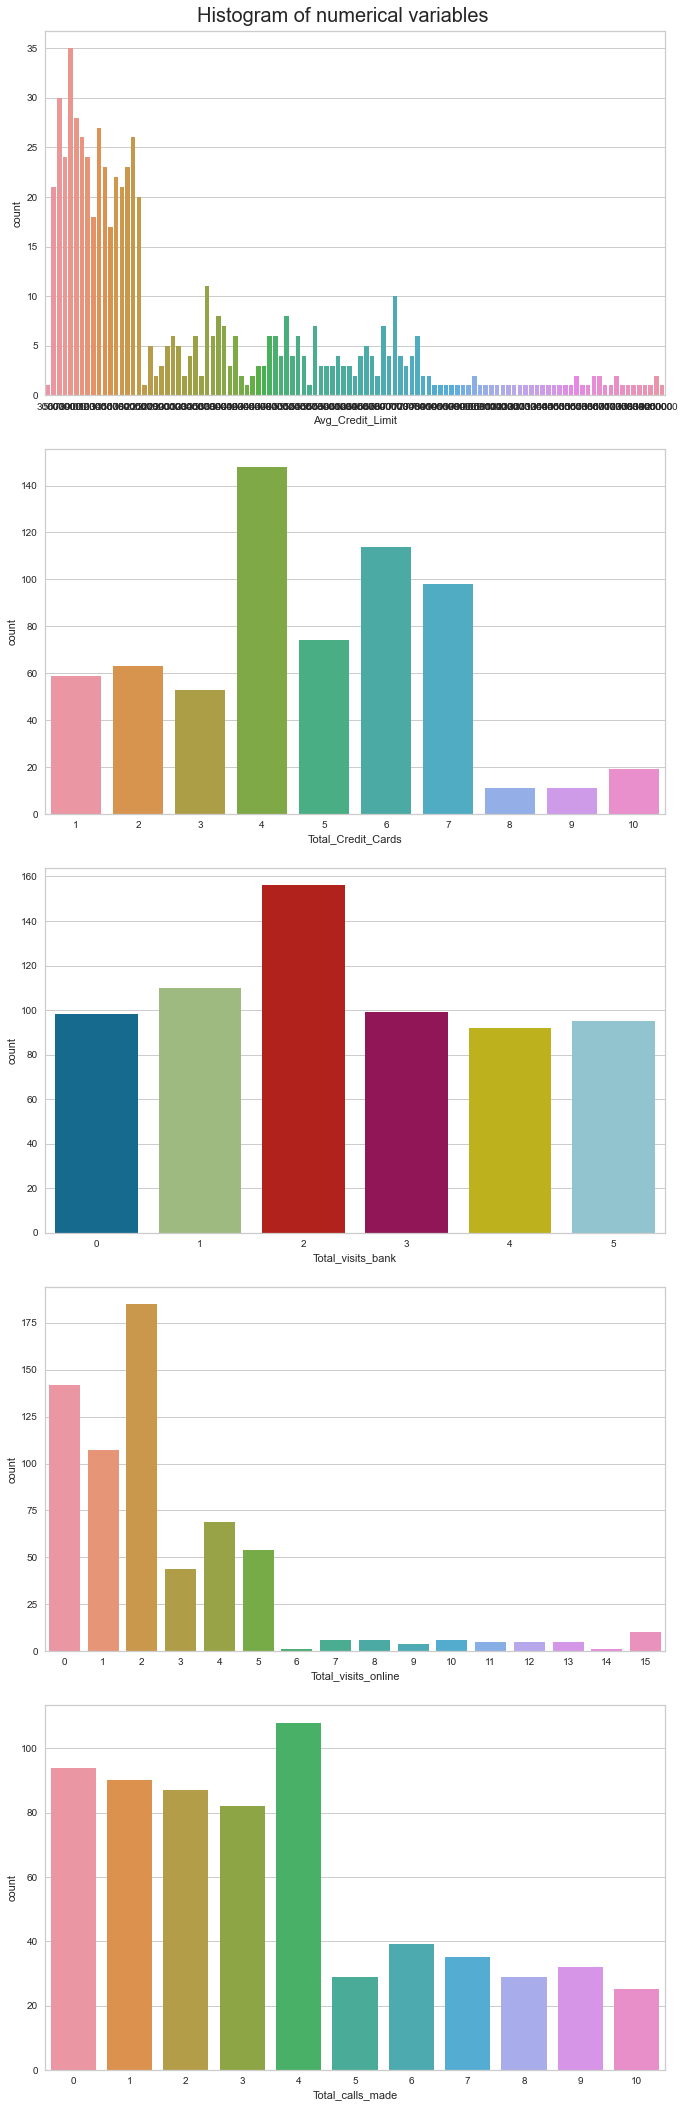

In [14]:
# Create countplots for each feature
all_col = df.columns.tolist() # create variable for the column names
fig, axes = plt.subplots(5, 1,  figsize=(10, 30)) # set the size and layout of the plot
fig.suptitle('Histogram of numerical variables', fontsize=20) # add a title
counter = 0
for ii in range(5): # define a function to create a countplot for each feature
    sns.countplot(ax=axes[ii],x=df[all_col[counter]])
    counter = counter+1

fig.tight_layout(pad=2.0)

#### Observations
* Most customers have a lower average credit limit (strong right skew)
* Most customers have between 4 and 7 credit cards
* 2 visits to the bank per customer is most common at almost 150 customers. Other values between 0 and 5 are fairly even at around 100
* Most customers made between 0 and 5 visits online. This feature has a right skew
* Most customers made 4 or fewer calls. This feature also has a right skew. 

### Boxplots of Numerical Columns

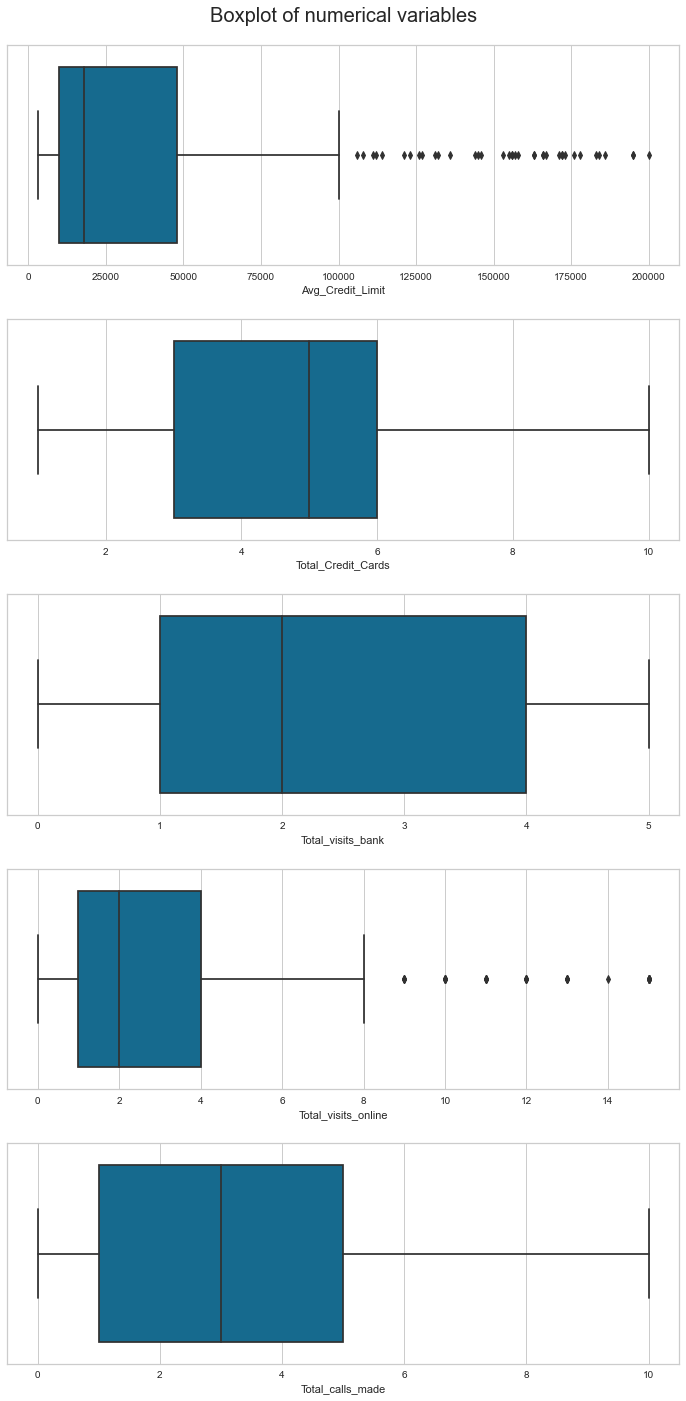

In [15]:
fig, axes = plt.subplots(5, 1,  figsize=(10,20)) # set the plot size
fig.suptitle('Boxplot of numerical variables', fontsize=20) # add a title
counter = 0
for ii in range(5): # define a function to create box plot for each feature
    sns.boxplot(ax=axes[ii],x=df[all_col[counter]])
    counter = counter+1

fig.tight_layout(pad=2.0)

#### Observations
* Almost all customers have a average credit limit under 100,000. 75% have an avg limit under 50,000. There are some outliers over 100,000
* 75% of customers have 6 or fewer credit cards. 50% have between 3 and 6
* 50% of customers visited the bank 1 to 4 times
* 75% of customers visited online 4 or fewer times. There are some outliers who visited more than 8 times online
* 50% of customers called 1 to 5 times

### KDE Plot

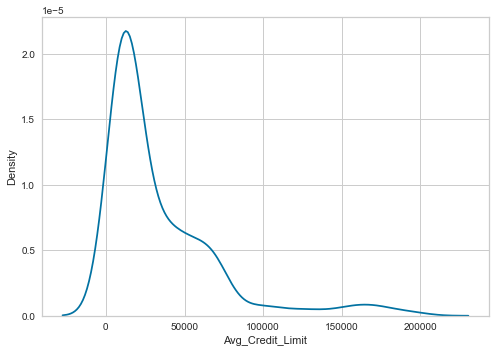

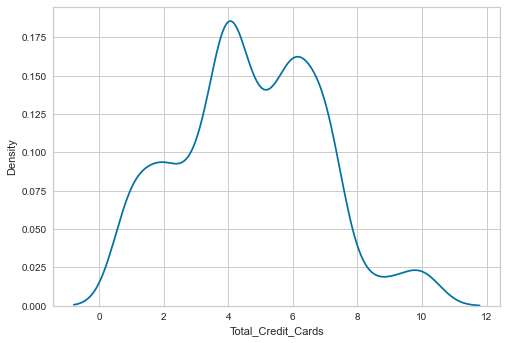

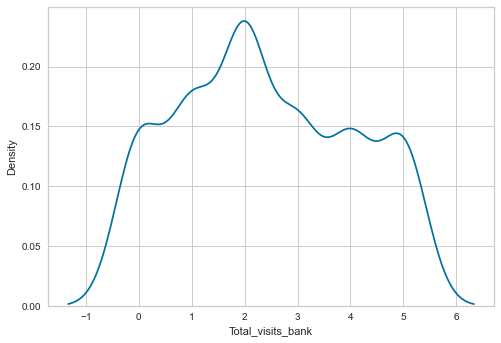

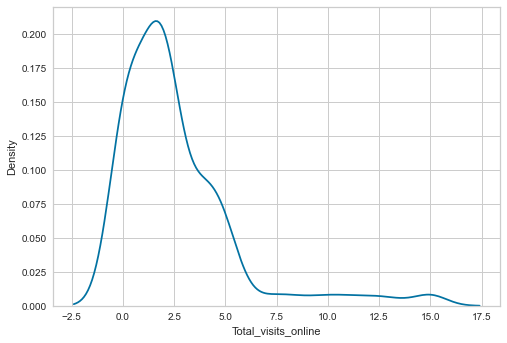

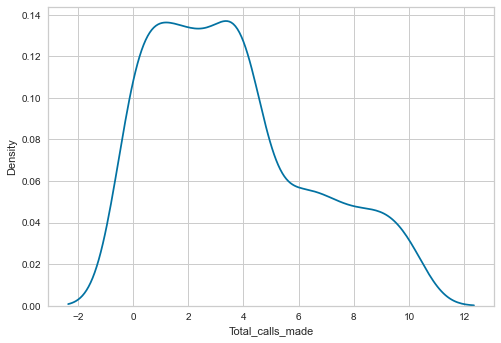

In [16]:
# Define function to create KDE plots for each column
# Check to see if I can spot the number of potential clusters

for i in df.columns:
    sns.kdeplot(data = df, x = i)
    plt.show()

#### Observations
* Avg Credit Limit and Total Visits Online have strong right skews.
* Avg Credit Limit and Total Visits Online have one large mode and two smaller ones
* Total Credit Cards has multiple modes, possibly 4
* Total Visits to the Bank has multiple modes
* Total Calls Made appears to be bi-modal (possibly 3) 

<a href = #TOC>Back to Top</a>

## <a id = "bivariate"></a>Bivariate Analysis

### Bivariate Analysis: Correlation Heatmap

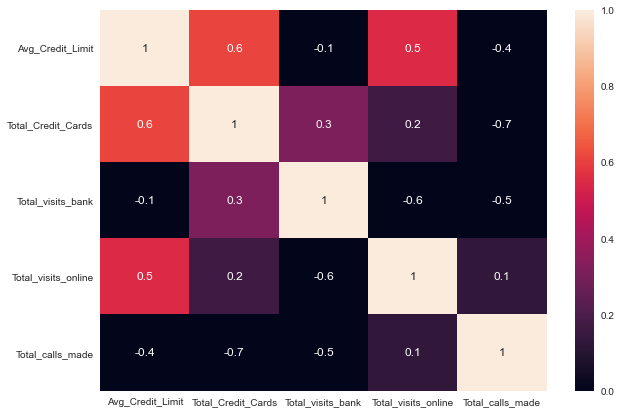

In [17]:
# Create a correlation heatmap to check for highly correlated features
plt.figure(figsize=(10,7))
sns.heatmap(df.corr(),annot=True,vmin=0,vmax=1,fmt='.1g')
plt.show()

#### Observations
* There is a moderate negative correlation (-0.7) between Total_calls_made and Total_Credit_Cards. Not sure why this is a negative correlation, I would want to ask the business SMEs for more info.  
* Total_visits_online and Total_visits_bank has a moderate negative correlation (-0.6). Might suggest that people who actively use online services visit the bank lest often and vice versa. 
* Total_Credit_Cards and Avg_Credit_Limit have a moderate positive correlation (0.6), which makes some sense. The more credit cards someone has the more they use credit, which in turn often means they'll have a higher credit limit. 

## <a id = "eda-insights"></a>Summary Insights from EDA

* It is difficult to tell what the clusters might be from the EDA. THe KDE plots indicate that some clusters likely exist (because of multiple humps showing), but it is hard to see any relationships between the columns at this point. 
* The columns also do not see to have a strong correlation between them, so that also makes it difficult to see any potential clusters through the EDA itself. 

<a href = #TOC>Back to Top</a>

# <a id = "k-means"></a>3. K-Means Clustering

## Scale the Data

In [18]:
# Scale the data before clustering because of differences in magnitude

scaler = StandardScaler() # define a variable for StandardScaler function
subset = df.copy() # Create a copy of the original df
subset_scaled = scaler.fit_transform(subset) # Transform the copy of the df using StandardScaler

In [19]:
subset_scaled

array([[ 1.76649944, -1.24150235, -0.86293246, -0.54799577, -1.25848041],
       [ 0.42357806, -0.78116206, -1.47796108,  2.53151936,  1.89310794],
       [ 0.42357806,  1.0601991 , -0.86293246,  0.13634093,  0.14222553],
       ...,
       [ 2.97512868,  1.52053939, -0.86293246,  2.18935101, -0.90830393],
       [ 3.70030623,  2.44121997, -0.86293246,  4.24236109, -1.25848041],
       [ 3.56601409,  1.98087968, -1.47796108,  3.21585605, -0.55812744]])

In [20]:
# Create a dataframe using the scaled data
df_scaled = pd.DataFrame(subset_scaled,columns=subset.columns)

# View the first 5 rows of the scaled dataframe
df_scaled.head()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1.766499,-1.241502,-0.862932,-0.547996,-1.258480
1,0.423578,-0.781162,-1.477961,2.531519,1.893108
2,0.423578,1.060199,-0.862932,0.136341,0.142226
3,-0.113590,0.139519,-0.862932,-0.547996,0.142226
4,-0.382175,-0.781162,-1.477961,-0.547996,1.542931


## Create Clusters Using KMeans

In [21]:
clusters = range(1,9) # Set the range of clusters to try from 1 to 8
meanDistortions = [] # Create an empty list to hold the mean distorition for each k

for k in clusters: # Define a function to run Kmeans for each number of clusters (k) from 1 to 8
    model = KMeans(n_clusters=k) # Use KMeans as the model 
    model.fit(df_scaled) # Fit the model to the df with scaled values
    prediction = model.predict(df_scaled) # Predict using KMeans on the scaled data
    # Calculate the average distortion for each value of k
    distortion = sum(np.min(cdist(df_scaled, model.cluster_centers_, 'euclidean'), axis=1)) / df_scaled.shape[0]
                           
    meanDistortions.append(distortion) # Add average distortion for each k to the empty list

    print('Number of Clusters:', k, '\tAverage Distortion:', distortion)


Number of Clusters: 1 	Average Distortion: 2.005363399425087
Number of Clusters: 2 	Average Distortion: 1.4536709139566302
Number of Clusters: 3 	Average Distortion: 1.1459558163296042
Number of Clusters: 4 	Average Distortion: 1.046526370771242
Number of Clusters: 5 	Average Distortion: 0.990727085679412
Number of Clusters: 6 	Average Distortion: 0.9421304529550397
Number of Clusters: 7 	Average Distortion: 0.9090350279010798
Number of Clusters: 8 	Average Distortion: 0.8887692829418786


## Use the Elbow Method

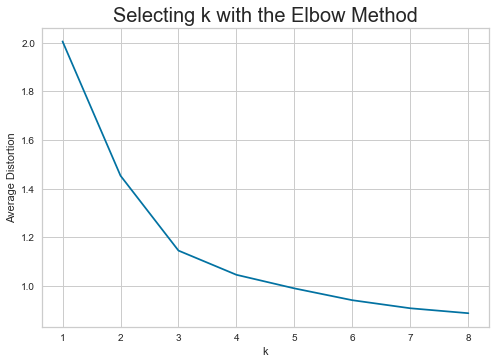

In [22]:
# Create a plot to visualize the elbow method, comparing avg distortion for each value of k
plt.plot(clusters, meanDistortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Average Distortion')
plt.title('Selecting k with the Elbow Method', fontsize=20)
plt.show()

### Observations
* Using the elbow method, the appropriate value for k appears to be 3 or 4
* The drop in distortion for each increase in k decreases quickly after 4, indicating that additional clusters add less incremental value

## Check the Silhouette Scores

In [23]:
sil_score = [] # Create an empty list to store each silhouette score
cluster_list = list(range(2,10)) # Define a variable for the number of clusters to check from 2 to 9
for n_clusters in cluster_list: # Define a function to calculate silhouette score for each number of clusters
    clusterer = KMeans(n_clusters=n_clusters) # Define KMeans as the clustering model
    preds = clusterer.fit_predict((df_scaled)) # Fit the the model on the scaled df
    score = silhouette_score(df_scaled, preds) # Calculate the silhouette score for each number of clusters
    sil_score.append(score) # Add the silhouette score for each number of clusters to the empty list
    print("For n_clusters = {}, silhouette score is {})".format(n_clusters, score))

For n_clusters = 2, silhouette score is 0.41929075804781274)
For n_clusters = 3, silhouette score is 0.5153584616976485)
For n_clusters = 4, silhouette score is 0.3548358237914311)
For n_clusters = 5, silhouette score is 0.2704976998177628)
For n_clusters = 6, silhouette score is 0.2552118533451781)
For n_clusters = 7, silhouette score is 0.24818278465614807)
For n_clusters = 8, silhouette score is 0.22697748116435912)
For n_clusters = 9, silhouette score is 0.2188958022839276)


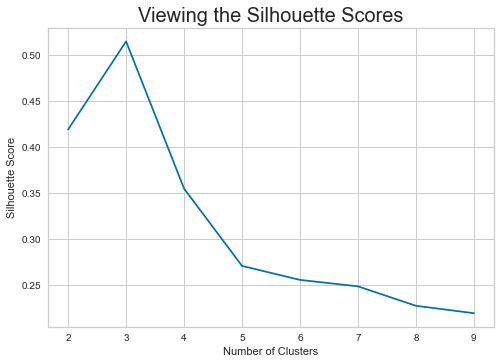

In [24]:
# Create a plot to view the silhouette scores for each number of clusters

plt.plot(cluster_list, sil_score)
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Viewing the Silhouette Scores', fontsize=20)
plt.show()

#### Observations
* Based on the silhouette score, 3 appears to be the optimum number of clusters
* After 3, the silhouette score decreases with each cluster, meaning the distance between the clusters reduces with greater numbers of clusters. 

## Visualize the Silhouette Coefficients
Checking for 2 through 5 cluster because silhouette cofficient change is minimal after 5

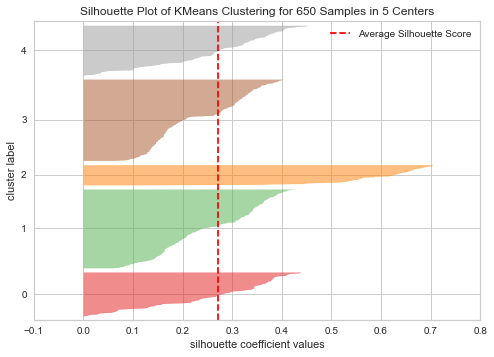

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 650 Samples in 5 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [25]:
# Use the SilhouetteVisualizer function to create a plot of the silhouette coefficients for each cluster
# Check with 5 clusters
visualizer = SilhouetteVisualizer(KMeans(5, random_state = 1)) 
visualizer.fit(df_scaled)    
visualizer.show()

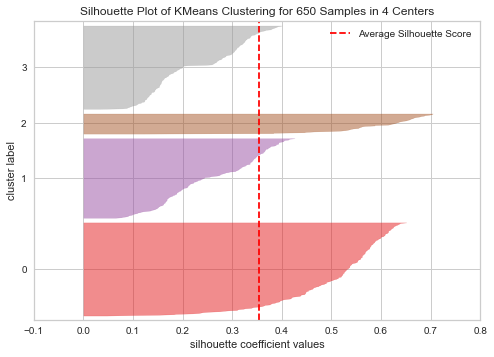

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 650 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [26]:
# Use the SilhouetteVisualizer function to create a plot of the silhouette coefficients for each cluster
# Check with 4 clusters
visualizer = SilhouetteVisualizer(KMeans(4, random_state = 1)) 
visualizer.fit(df_scaled)    
visualizer.show()

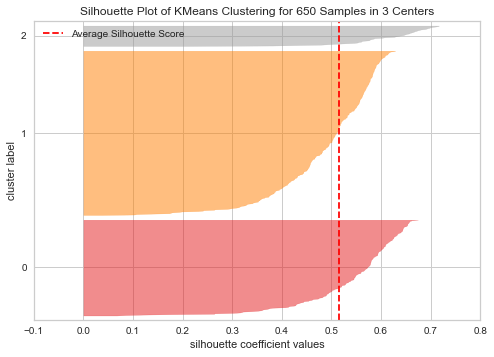

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 650 Samples in 3 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [27]:
# Use the SilhouetteVisualizer function to create a plot of the silhouette coefficients for each cluster
# Check with 3 clusters
visualizer = SilhouetteVisualizer(KMeans(3, random_state = 1)) 
visualizer.fit(df_scaled)    
visualizer.show()

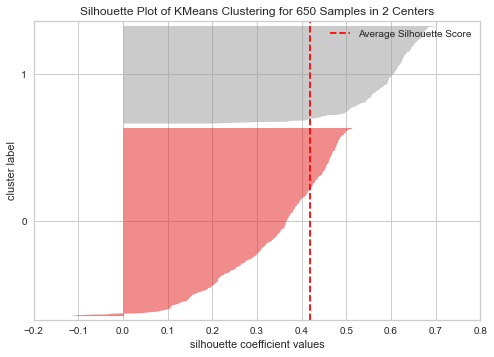

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 650 Samples in 2 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [28]:
# Use the SilhouetteVisualizer function to create a plot of the silhouette coefficients for each cluster
# Check with 2 clusters
visualizer = SilhouetteVisualizer(KMeans(2, random_state = 1)) 
visualizer.fit(df_scaled)    
visualizer.show()

### Observations
* 3 clusters has the highest silhouette score, 
* 4 seems to more evenly distribute customers into segments, but two clusters look very similar and the silhouette score drops significantly.
* I will choose 3 clusters based on the combination of the Elbow Method, Silhouette Scores, and EDA. 

## Create Final KMeans Model

In [29]:
# Create final KMeans model using 3 clusters
kmeans = KMeans(n_clusters=3, random_state=0)

# Fit model on the scaled data
kmeans.fit(df_scaled)

KMeans(n_clusters=3, random_state=0)

In [30]:
# Add KMeans labels to the original dataframe
df['K_means_segments'] = kmeans.labels_

# Add KMeans lables to the scaled dataframe
df_scaled['K_means_segments'] = kmeans.labels_

In [31]:
# Create a dataframe with the original data grouped by the KMeans segments/labels
KMeans_profile = df.groupby('K_means_segments').mean()

KMeans_profile

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
K_means_segments,,,,,
0,33631.578947,5.513158,3.486842,0.981579,2.010526
1,12180.180180,2.405405,0.936937,3.567568,6.851351
2,140937.500000,8.833333,0.604167,10.958333,1.062500


In [32]:
# Add a count column to the new dataframe
KMeans_profile['Count_in_Segment'] = df.groupby('K_means_segments')['Avg_Credit_Limit'].count().values

# Display the dataframe with the newly added column showing count in each segment
KMeans_profile

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,Count_in_Segment
K_means_segments,,,,,,
0,33631.578947,5.513158,3.486842,0.981579,2.010526,380
1,12180.180180,2.405405,0.936937,3.567568,6.851351,222
2,140937.500000,8.833333,0.604167,10.958333,1.062500,48


## Create Boxplots for Final KMeans Model Segments

In [33]:
# Add columns to a list so I can use it in a function later
cols = df_scaled.columns[0:5].tolist()

cols

['Avg_Credit_Limit',
 'Total_Credit_Cards',
 'Total_visits_bank',
 'Total_visits_online',
 'Total_calls_made']

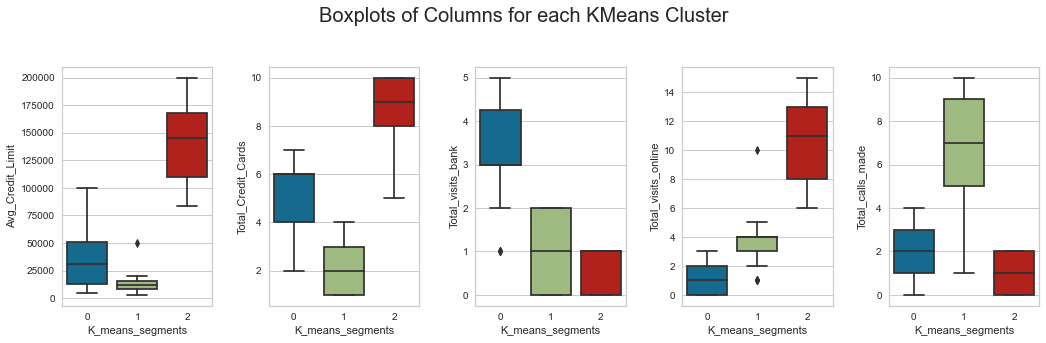

In [34]:
fig, axes = plt.subplots(1, 5, figsize=(15, 5)) # Define the size and layout of the plot
fig.suptitle('Boxplots of Columns for each KMeans Cluster', fontsize=20)
counter = 0
for ii in range(5): # Define a function to create a boxplot for each feature in the scaled df
    sns.boxplot(ax=axes[ii],y=df[cols[counter]],x=df['K_means_segments'])
    counter = counter+1

fig.tight_layout(pad=2.0)

## KMeans Segment Insights:
**Segment 0: In-Person Customers**
* Most customers have an average credit limit between 15,000 and 50,000, and all have an average limit of 100,000 or less
* These customers have 2 to 7 credit cards, with most having 4 to 6.
* These cusomters visit the bank in person much more often than other segments. The visit 2 to 5 times, with most visiting 3 to 4 times
* These customers are not heavy online users -- most have visited the online site 0 to 2 times
* These customers call fairly infrequently -- 1 to 3 times
* Overall, I would call this segment the "In-Person Customers" because their differentiating trait is that they tend to visit in-person much more often than the other two clusters. Because of their preference for in-person visits, they don't use the online site hardly at all and they don't call very often. 

**Segment 1: Phone Customers**
* These customers have by far the lowest average credit limit -- almost all are under 25,000, with most around 15,000. 
* These customers also have the fewest credit cards -- all with 4 or fewer. Most have 1 to 3 credit cards. 
* These customers do not visit the bank in-person very often -- all visit 0 to 2 times
* These customers use the online site some, but still not often. Most use the online site 3 to 4 times
* These customers have a strong preference for the phone. They call more often than the other clusters. 50% call 5 to 9 times. The next highest segment has a max of 4 calls. 
* Overall, I would call this segment the "Phone Customers" because of their strong preference for phone-based interaction. It is their differentiating factor, though they are also unique in having lower credit limits and fewer credit cards. 

**Segment 2: Online Customers**
* These customers have much higher average credit limits, ranging from 80,000 to 200,000. 50% have avg credit limits between 110,000 and 160,000 while the next highest segment has a max avg credit limit of 100,000. 
* These customers also have a lot more credit cards -- 50 % of them have 8 to 10 cards while the next highest segment averages 4 to 6
* These customers rarely visit the bank in person. None of them has visited more than once. 
* These customers use the online channel frequently -- 50% have 8 to 13 online visits while the next highest segment averages 3 to 4. 
* These customers also don't like to call -- none has called more than twice. 

<a href = #TOC>Back to Top</a>

# <a id = "hierarchical"></a>4. Hierarchical Clustering

## Create Another Copy of the Scaled Dataframe for Hierarchical Clustering

In [35]:
# Create another dataframe using the scaled data
df_scaled2 = pd.DataFrame(subset_scaled,columns=subset.columns)

# View the first 5 rows of the scaled dataframe
df_scaled2.head()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1.766499,-1.241502,-0.862932,-0.547996,-1.258480
1,0.423578,-0.781162,-1.477961,2.531519,1.893108
2,0.423578,1.060199,-0.862932,0.136341,0.142226
3,-0.113590,0.139519,-0.862932,-0.547996,0.142226
4,-0.382175,-0.781162,-1.477961,-0.547996,1.542931


## Ward Method

### Calculate the Cophenetic Index

In [36]:
# Create linkage matrix using the scaled data, Ward method, and euclidean distance
Z = linkage(df_scaled2, method='ward', metric='euclidean')

# Calculate the cophenetic index and the cophenetic distances
c, coph_dists = cophenet(Z , pdist(df_scaled2))

# Display the cophenetic index
c

0.7379966488639899

#### Observations
* The cophenetic index is 0.74, which means it is fitting OK, but not excellent. 

### Plot the Dendrogram

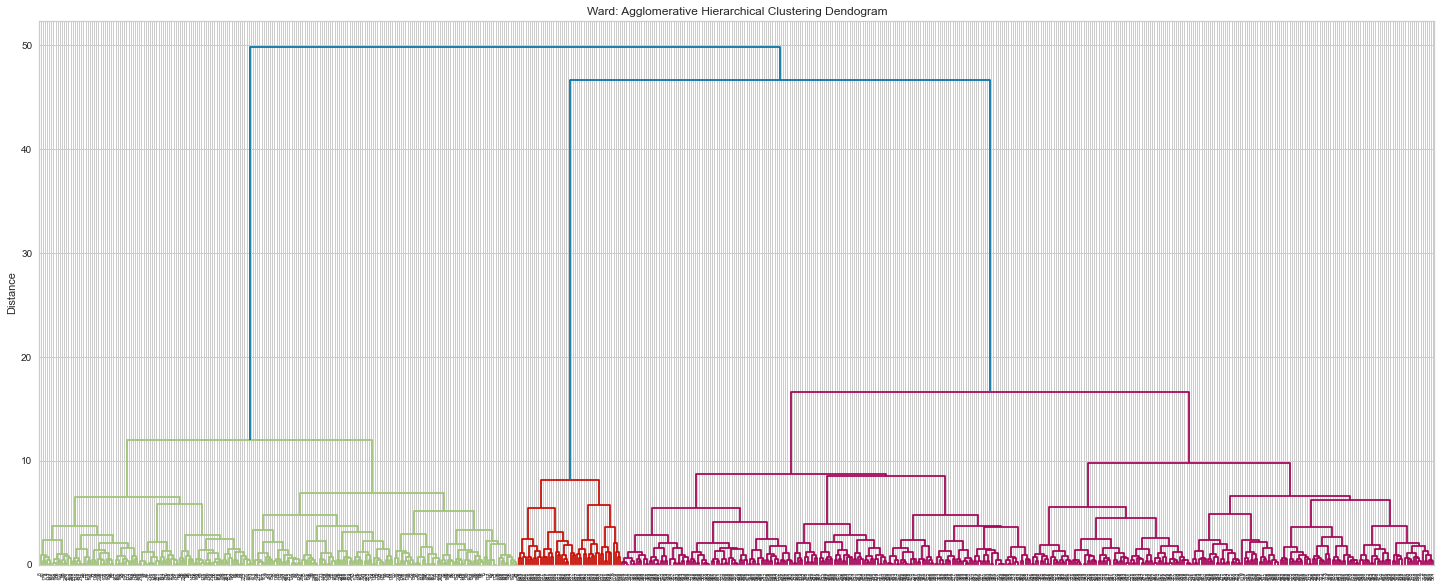

In [37]:
plt.figure(figsize=(25, 10))
plt.title('Ward: Agglomerative Hierarchical Clustering Dendogram')
plt.ylabel('Distance')
dendrogram(Z)
plt.show()

#### Observations
* Dendrogram using the Ward method is showing 3 distinct clusters

## Average Method

### Calculate the Cophenetic Index

In [38]:
# Create linkage matrix using the scaled data, Average method, and euclidean distance
Z = linkage(df_scaled2, method='average', metric='euclidean')

# Calculate the cophenetic index and the cophenetic distances
c, coph_dists = cophenet(Z , pdist(df_scaled2))

# Display the cophenetic index
c

0.8976551428407843

#### Observations
* Much higher cophenetic index using the Average method at 0.9, very close to 1.0, indicating good cluster quality

### Plot the Dendrogram

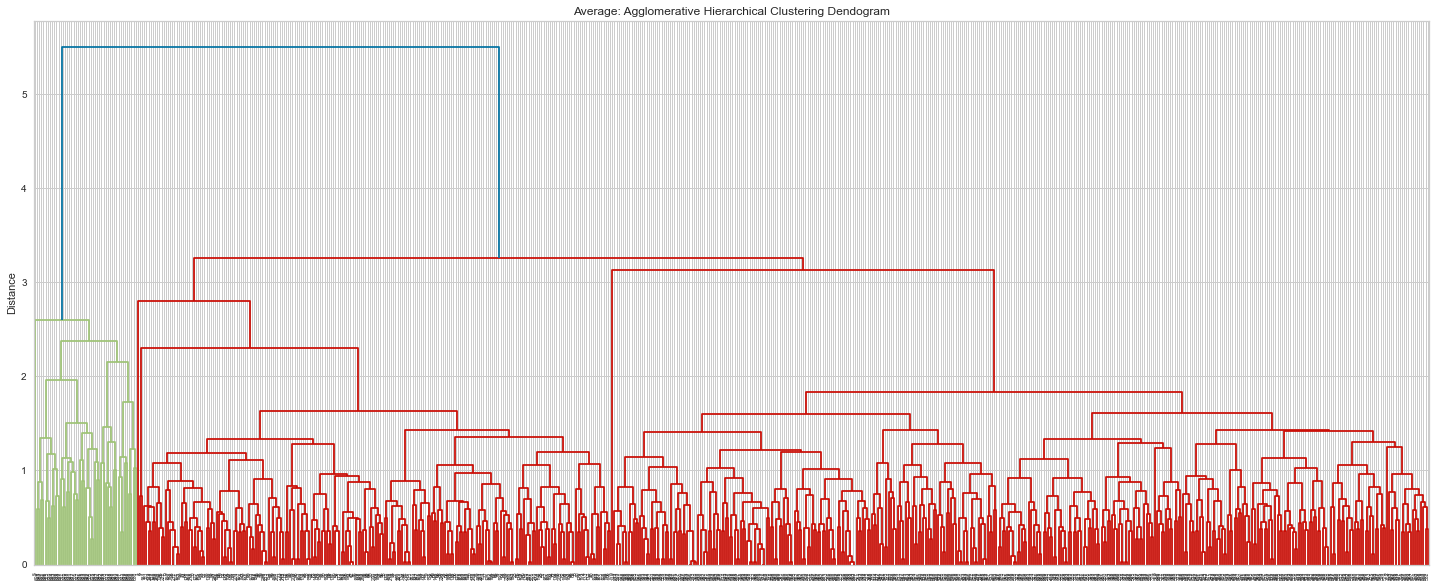

In [39]:
plt.figure(figsize=(25, 10))
plt.title('Average: Agglomerative Hierarchical Clustering Dendogram')
plt.ylabel('Distance')
dendrogram(Z)
plt.show()

#### Observations
* Dendrogram from the Average method is showing 2 distinct clusters, but could be 3 if the threshold was set a little over 3 on the distance

## Complete Method

### Calculate the Cophenetic Index

In [40]:
# Create linkage matrix using the scaled data, Complete method, and euclidean distance
Z = linkage(df_scaled2, method='complete', metric='euclidean')

# Calculate the cophenetic index and the cophenetic distances
c, coph_dists = cophenet(Z , pdist(df_scaled2))

# Display the cophenetic index
c

0.875762954637019

#### Observations
* Very good cophenetic index at 0.88, but not as good as with the Average method

### Plot the Dendrogram

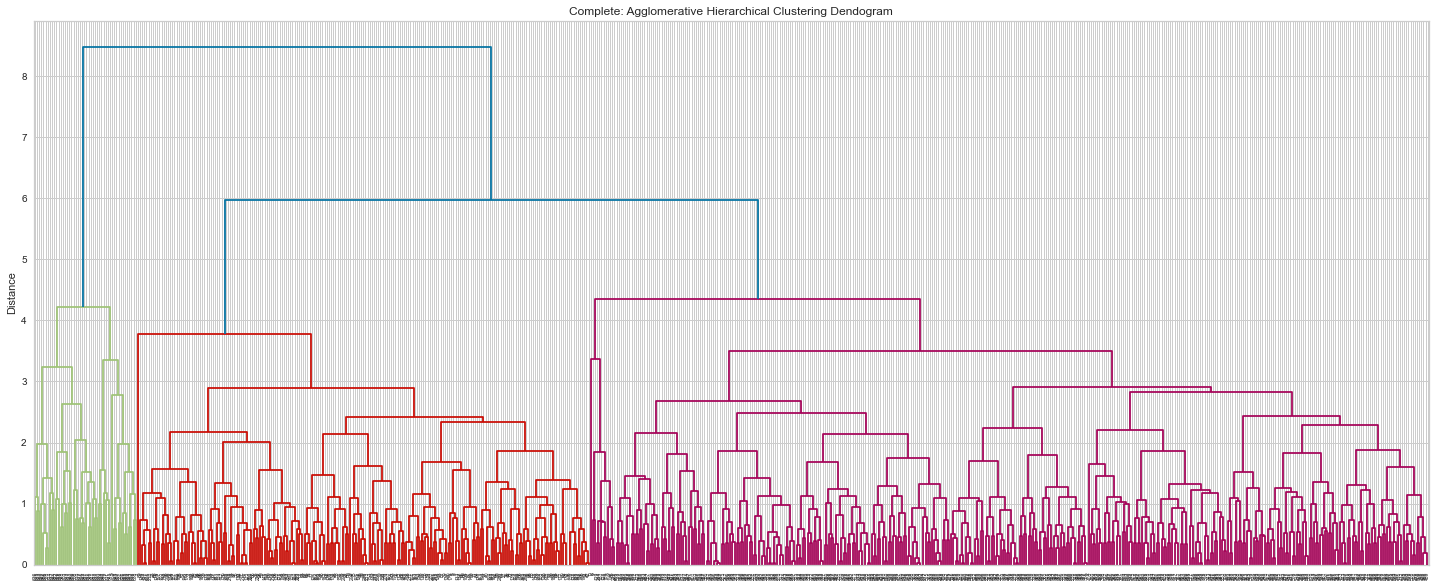

In [41]:
plt.figure(figsize=(25, 10))
plt.title('Complete: Agglomerative Hierarchical Clustering Dendogram')
plt.ylabel('Distance')
dendrogram(Z)
plt.show()

#### Observations
* The dendrogram with the Complete method is showing 3 distinct clusters

## Compare More Combinations of Linkage Methods and Distances

In [42]:
distance_metrics = [ 'euclidean','chebyshev','mahalanobis','cityblock'] # Create list of distance metrics to check
linkage_methods = ['single', 'complete', 'average', 'weighted'] # Create list of linkage methods to check
high_cophenet_corr = 0 # Create a variable so the function can assign the highest cophenetic correlation
high_dm_lm = [0,0] # Create a variable so the function can assign the best distance metric and linkage method combination

for dm in distance_metrics: # Create a function to check all combinations of distance metrics and linkage methods
    for lm in linkage_methods:
        Z = linkage(df_scaled2, metric=dm, method=lm)
        c, coph_dists = cophenet(Z , pdist(df_scaled2))
        print('Cophenetic correlation for distance metric {} and linkage method {} is {}'.format(dm,lm,c))
        if high_cophenet_corr < c:
            high_cophenet_corr = c
            high_dm_lm[0] = dm
            high_dm_lm[1] = lm

Cophenetic correlation for distance metric euclidean and linkage method single is 0.7395674464262232
Cophenetic correlation for distance metric euclidean and linkage method complete is 0.875762954637019
Cophenetic correlation for distance metric euclidean and linkage method average is 0.8976551428407843
Cophenetic correlation for distance metric euclidean and linkage method weighted is 0.8464670852814933
Cophenetic correlation for distance metric chebyshev and linkage method single is 0.7386098939096654
Cophenetic correlation for distance metric chebyshev and linkage method complete is 0.8439443039744918
Cophenetic correlation for distance metric chebyshev and linkage method average is 0.8961002468002037
Cophenetic correlation for distance metric chebyshev and linkage method weighted is 0.8268585193923553
Cophenetic correlation for distance metric mahalanobis and linkage method single is 0.7064039538714036
Cophenetic correlation for distance metric mahalanobis and linkage method comple

In [43]:
print('Highest cophenetic index is {}, which is obtained with {} distance metric and {} linkage method'.format(high_cophenet_corr ,high_dm_lm[0],high_dm_lm[1]))

Highest cophenetic index is 0.8976551428407843, which is obtained with euclidean distance metric and average linkage method


#### Observations
* Several combinations give good cophenetic index scores
* Average and Eucledian combination still provides highest score as I found earlier in the initial checking I did
* Average linkage method gives high scores with all of the distance metrics

In [44]:
# Checking some additional combinations that can only use Euclidean distance 

linkage_methods = ['median','ward', 'centroid']
high_cophenet_corr = 0
high_dm_lm = [0,0]

for lm in linkage_methods:
    Z = linkage(df_scaled2, metric='euclidean', method=lm)
    c, coph_dists = cophenet(Z , pdist(df_scaled2))
    print('Cophenetic index for distance metric {} and linkage method {} is {}'.format('euclidean',lm,c))
    if high_cophenet_corr < c:
        high_cophenet_corr = c
        high_dm_lm[0] = dm
        high_dm_lm[1] = lm

Cophenetic index for distance metric euclidean and linkage method median is 0.8861796259701693
Cophenetic index for distance metric euclidean and linkage method ward is 0.7379966488639899
Cophenetic index for distance metric euclidean and linkage method centroid is 0.8939026465042819


In [45]:
print('Highest cophenetic index for methods that require Euclidean distance is {}, which is obtained with {} linkage method'.format(high_cophenet_corr ,high_dm_lm[1]))

Highest cophenetic index for methods that require Euclidean distance is 0.8939026465042819, which is obtained with centroid linkage method


#### Observations
* Centroid linkage method gives a very good cophenetic index score with Euclidean distance, but it's still just below the combination of Euclidean and Average linkage method

### Create Dendrograms for Additional Combinations with Euclidean

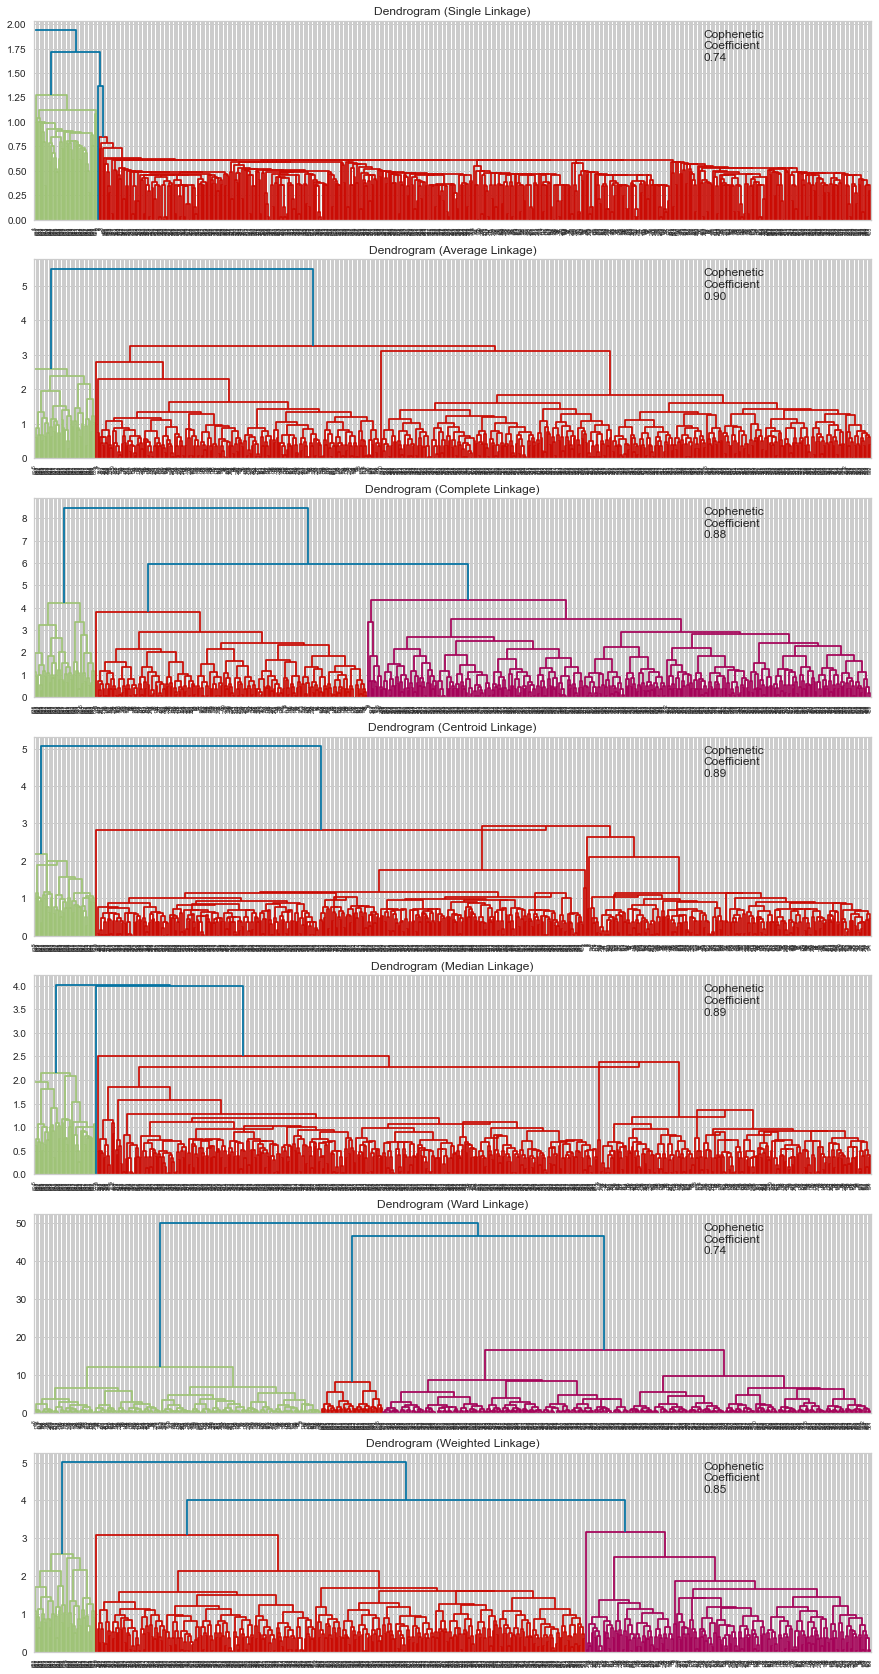

In [46]:
# Create a list of all linkage methods to check
methods = ['single',
           'average', 
           'complete',
           'centroid',
           'median',
           'ward',
           'weighted']

# Create lists to save results of cophenetic index calculation
compare_cols = ['Linkage', 'Cophenetic Coefficient']
compare = []

# Create a subplot 
fig, axs = plt.subplots(len(methods), 1, figsize=(15, 30))

# Enumerate through the list of all the linkage methods above
# Get linkage, plot dendrogram, calculate cophenetic coefficient
for i, method in enumerate(methods):
    
    Z = linkage(df_scaled2, metric='euclidean', method=method)

    dendrogram(Z, ax=axs[i]);
    axs[i].set_title(f'Dendrogram ({method.capitalize()} Linkage)')
    coph_corr, coph_dist = cophenet(Z, pdist(df_scaled2))
    axs[i].annotate(f'Cophenetic\nCoefficient\n{coph_corr:0.2f}', 
                    (0.80, 0.80),
                    xycoords='axes fraction')
    compare.append([method, coph_corr])

#### Observations
* x

In [47]:
# Create and print dataframe to compare Cophenetic Coefficient for each linkage method
df_cc = pd.DataFrame(compare, columns=compare_cols)
df_cc.sort_values(by='Cophenetic Coefficient', ascending=False)

,Linkage,Cophenetic Coefficient
1,average,0.897655
3,centroid,0.893903
4,median,0.886180
2,complete,0.875763
6,weighted,0.846467
0,single,0.739567
5,ward,0.737997


#### Observations
* Complete, Weighted, and Ward gives 3 distinct clusters. The others provide 2. 
* Of the 3 methods that give 3 clusters, Complete has the highest Cophenetic score
* Ward has the lowest Cophenetic Coefficient but appears to create the clearest clusters, so I will use it for calculating the silhouette scores

## Calculate Silhouette Scores for Hierarchical Clustering

In [48]:
sil_score2 = [] # Create an empty list to store each silhouette score
cluster_list2 = list(range(2,10)) # Define a variable for the number of clusters to check from 2 to 9
for n_clusters in cluster_list2: # Define a function to calculate silhouette score for each number of clusters
    clusterer2 = AgglomerativeClustering(n_clusters=n_clusters,affinity='euclidean', linkage='ward') # Define Agglomerative Clustering as the clustering model
    preds2 = clusterer2.fit_predict((df_scaled2)) # Fit the the model on the scaled df
    score2 = silhouette_score(df_scaled2, preds2) # Calculate the silhouette score for each number of clusters
    sil_score2.append(score2) # Add the silhouette score for each number of clusters to the empty list
    print("For n_clusters = {}, silhouette score is {})".format(n_clusters, score2))

For n_clusters = 2, silhouette score is 0.41856781278083766)
For n_clusters = 3, silhouette score is 0.5143991483266315)
For n_clusters = 4, silhouette score is 0.3471127984833349)
For n_clusters = 5, silhouette score is 0.25593453288356044)
For n_clusters = 6, silhouette score is 0.22748744293818976)
For n_clusters = 7, silhouette score is 0.21550222198373076)
For n_clusters = 8, silhouette score is 0.22265458376332048)
For n_clusters = 9, silhouette score is 0.20004222016073672)


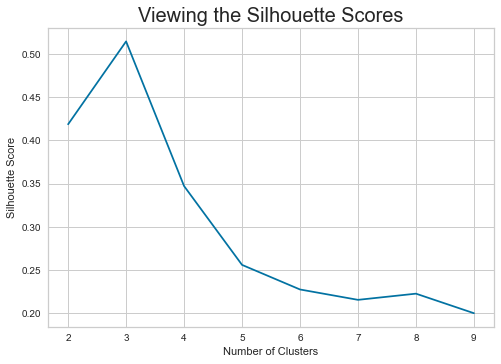

In [49]:
# Create a plot to view the silhouette scores for each number of clusters

plt.plot(cluster_list2, sil_score2)
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Viewing the Silhouette Scores', fontsize=20)
plt.show()

#### Observations
* I used multiple linkage methods and ultimately decided on Ward, which was giving good results.
* Looking at the average Silhouette coefficient confirms that 3 is a good choice. 
* I will create the final Hierarchical Clustering model with 3 clusters

## Create Final Clusters from Hierarchical Clustering Results

In [50]:
# Create a hierarchical clustering model with k=3, Ward linkage method, and Euclidean distance
HCmodel = AgglomerativeClustering(n_clusters=3,affinity='euclidean', linkage='ward')
HCmodel.fit(df_scaled2)
df_scaled2['HC_Clusters'] = HCmodel.labels_
df['HC_Clusters'] = HCmodel.labels_

In [51]:
# Create a dataframe to show the cluster profile, group by the clusters and calculate the average for each column
HC_cluster_profile = df.copy()
HC_cluster_profile.drop('K_means_segments', axis=1, inplace=True)
HC_cluster_profile = HC_cluster_profile.groupby('HC_Clusters').mean()

HC_cluster_profile

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
HC_Clusters,,,,,
0,33701.846966,5.514512,3.490765,0.978892,2.005277
1,12156.950673,2.417040,0.941704,3.560538,6.838565
2,140937.500000,8.833333,0.604167,10.958333,1.062500


In [52]:
# Add a column with the count of the number of customers in each segment/cluster
HC_cluster_profile['count_in_each_segment'] = df.groupby('HC_Clusters')['Avg_Credit_Limit'].count().values

# Display the Hierarchical Clusters with average values for each column and a count of customers in each segment
HC_cluster_profile

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,count_in_each_segment
HC_Clusters,,,,,,
0,33701.846966,5.514512,3.490765,0.978892,2.005277,379
1,12156.950673,2.417040,0.941704,3.560538,6.838565,223
2,140937.500000,8.833333,0.604167,10.958333,1.062500,48


### Observations
* The count in each segment is almost identical to what was obtained through KMeans clustering
* The averages for each column by segment are all very similar as well 

## Boxplots for each Column by Segment

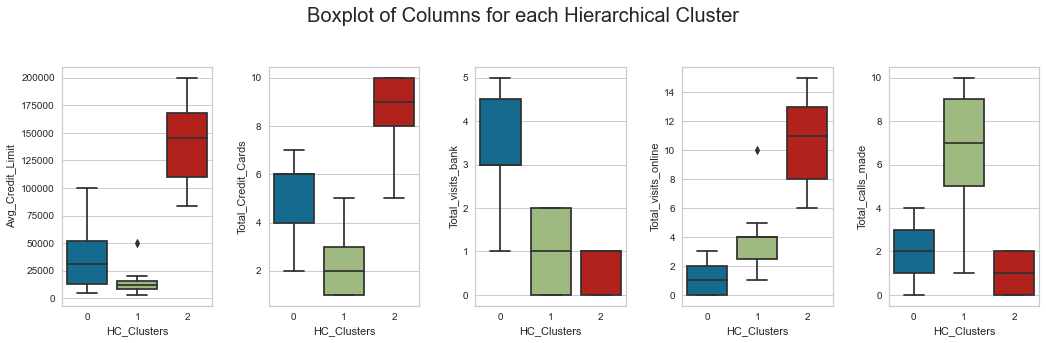

In [53]:
fig, axes = plt.subplots(1, 5, figsize=(15, 5)) # Define the size and layout of the plot
fig.suptitle('Boxplot of Columns for each Hierarchical Cluster', fontsize=20)
counter = 0
for ii in range(5): # Define a function to create a boxplot for each feature in the scaled df
    sns.boxplot(ax=axes[ii],y=df[cols[counter]],x=df['HC_Clusters'])
    counter = counter+1

fig.tight_layout(pad=2.0)

#### Observations
* The boxplots are nearly identical to the ones created through KMeans clustering. 

## Hierarchical Cluster Insights:
**Cluster 0: In-Person Customers**
* Most customers have an average credit limit between 15,000 and 50,000, and all have an average limit of 100,000 or less
* These customers have 2 to 7 credit cards, with most having 4 to 6.
* These cusomters visit the bank in person much more often than other segments. The visit 1 to 5 times, with most visiting 3 to 4 times
* These customers are not heavy online users -- most have visited the online site 0 to 3 times
* These customers call fairly infrequently -- most call 1 to 3 times
* Overall, I would call this segment the "In-Person Customers" because their differentiating trait is that they tend to visit in-person much more often than the other two clusters. Because of their preference for in-person visits, they don't use the online site hardly at all and they don't call very often. 

**Cluster 1: Phone Customers**
* These customers have by far the lowest average credit limit -- almost all are under 25,000, with most around 15,000. 
* These customers also have the fewest credit cards -- all with 4 or fewer. Most have 1 to 3 credit cards. 
* These customers do not visit the bank in-person very often -- all visit 0 to 2 times
* These customers use the online site some, but still not often. Most use the online site 3 to 4 times
* These customers have a strong preference for the phone. They call more often than the other clusters. 50% call 5 to 9 times. The next highest segment has a max of 4 calls. 
* Overall, I would call this segment the "Phone Customers" because of their strong preference for phone-based interaction. It is their differentiating factor, though they are also unique in having lower credit limits and fewer credit cards. 

**Cluster 2: Online Customers**
* These customers have much higher average credit limits, ranging from 80,000 to 200,000. 50% have avg credit limits between 110,000 and 160,000 while the next highest segment has a max avg credit limit of 100,000. 
* These customers also have a lot more credit cards -- 50 % of them have 8 to 10 cards while the next highest segment averages 4 to 6
* These customers rarely visit the bank in person. None of them has visited more than once. 
* These customers use the online channel frequently -- 50% have 8 to 13 online visits while the next highest segment averages 3 to 4. 
* These customers also don't like to call -- none has called more than twice. 

<a href = #TOC>Back to Top</a>

# 5. Average Silhouette Scores

<div class="alert alert-warning">I calucated the average silhouette scores for each method in previous steps when deciding the number of clusters to use. I'll repeat the averages and visuals here for comparison of the two final methods. </div>

## Average Silhouette: KMeans

In [54]:
sil_score = [] # Create an empty list to store each silhouette score
cluster_list = list(range(2,10)) # Define a variable for the number of clusters to check from 2 to 9
for n_clusters in cluster_list: # Define a function to calculate silhouette score for each number of clusters
    clusterer = KMeans(n_clusters=n_clusters) # Define KMeans as the clustering model
    preds = clusterer.fit_predict((df_scaled)) # Fit the the model on the scaled df
    score = silhouette_score(df_scaled, preds) # Calculate the silhouette score for each number of clusters
    sil_score.append(score) # Add the silhouette score for each number of clusters to the empty list
    print("For n_clusters = {}, silhouette score is {})".format(n_clusters, score))

For n_clusters = 2, silhouette score is 0.4346858770815947)
For n_clusters = 3, silhouette score is 0.5407957345774412)
For n_clusters = 4, silhouette score is 0.3680327550364634)
For n_clusters = 5, silhouette score is 0.27581206760385096)
For n_clusters = 6, silhouette score is 0.25970943148253645)
For n_clusters = 7, silhouette score is 0.2524234847328246)
For n_clusters = 8, silhouette score is 0.22925805424881918)
For n_clusters = 9, silhouette score is 0.22930720598230567)


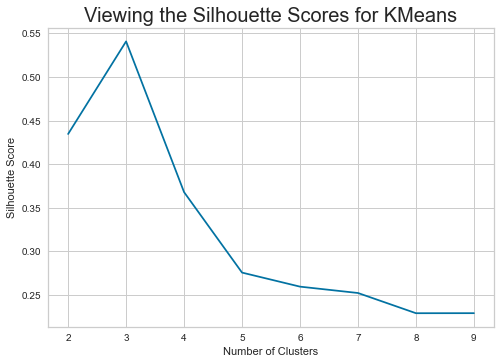

In [55]:
# Create a plot to view the silhouette scores for each number of clusters

plt.plot(cluster_list, sil_score)
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Viewing the Silhouette Scores for KMeans', fontsize=20)
plt.show()

## Average Silhouette: Hierarchical Clustering 

In [56]:
sil_score2 = [] # Create an empty list to store each silhouette score
cluster_list2 = list(range(2,10)) # Define a variable for the number of clusters to check from 2 to 9
for n_clusters in cluster_list2: # Define a function to calculate silhouette score for each number of clusters
    clusterer2 = AgglomerativeClustering(n_clusters=n_clusters,affinity='euclidean', linkage='ward') # Define Agglomerative Clustering as the clustering model
    preds2 = clusterer2.fit_predict((df_scaled2)) # Fit the the model on the scaled df
    score2 = silhouette_score(df_scaled2, preds2) # Calculate the silhouette score for each number of clusters
    sil_score2.append(score2) # Add the silhouette score for each number of clusters to the empty list
    print("For n_clusters = {}, silhouette score is {})".format(n_clusters, score2))

For n_clusters = 2, silhouette score is 0.4333200928005424)
For n_clusters = 3, silhouette score is 0.5399849768349687)
For n_clusters = 4, silhouette score is 0.3603630546403628)
For n_clusters = 5, silhouette score is 0.26043359103206426)
For n_clusters = 6, silhouette score is 0.23159723840850627)
For n_clusters = 7, silhouette score is 0.21961201745404726)
For n_clusters = 8, silhouette score is 0.22676437923363696)
For n_clusters = 9, silhouette score is 0.2015825161868314)


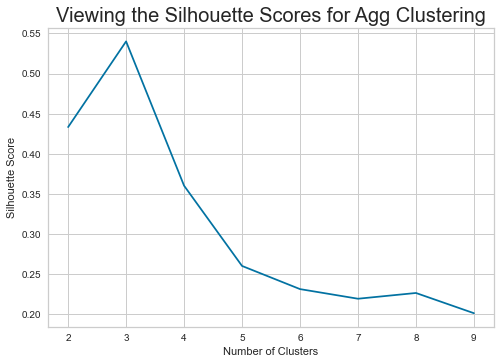

In [57]:
# Create a plot to view the silhouette scores for each number of clusters

plt.plot(cluster_list2, sil_score2)
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Viewing the Silhouette Scores for Agg Clustering', fontsize=20)
plt.show()

#### Observations
* The average silhouette scores are slightly higher for AgglomerativeClustering in this case, but not a big difference
* The results are suprisingly similar. Both methods have very similar increases and decreases in silhouette scores as the number of clusters increases

<a href = #TOC>Back to Top</a>

# 6. Comparison of K-Means Clusters to Hierarchical Clusters

The project instructions ask us to compare each cluser of K-Means to Hierarchical Clusters. I'm interpreting that as looking at how the clusters formed by each method are similar and different. 

## Final K-Means Clusters

In [58]:
# Display the dataframe with the final K-Means segments/clusters
KMeans_profile

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,Count_in_Segment
K_means_segments,,,,,,
0,33631.578947,5.513158,3.486842,0.981579,2.010526,380
1,12180.180180,2.405405,0.936937,3.567568,6.851351,222
2,140937.500000,8.833333,0.604167,10.958333,1.062500,48


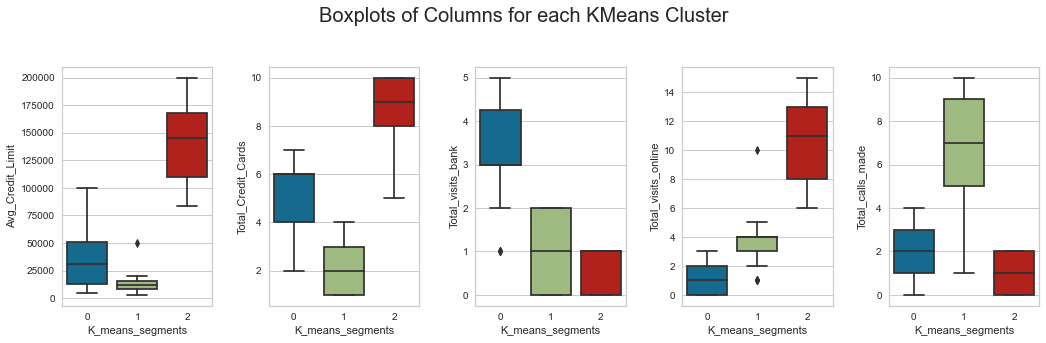

In [59]:
fig, axes = plt.subplots(1, 5, figsize=(15, 5)) # Define the size and layout of the plot
fig.suptitle('Boxplots of Columns for each KMeans Cluster', fontsize=20)
counter = 0
for ii in range(5): # Define a function to create a boxplot for each feature in the scaled df
    sns.boxplot(ax=axes[ii],y=df[cols[counter]],x=df['K_means_segments'])
    counter = counter+1

fig.tight_layout(pad=2.0)

## Final Hierarchical Clusters

In [60]:
# Display the Hierarchical Clusters with average values for each column and a count of customers in each segment
HC_cluster_profile

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,count_in_each_segment
HC_Clusters,,,,,,
0,33701.846966,5.514512,3.490765,0.978892,2.005277,379
1,12156.950673,2.417040,0.941704,3.560538,6.838565,223
2,140937.500000,8.833333,0.604167,10.958333,1.062500,48


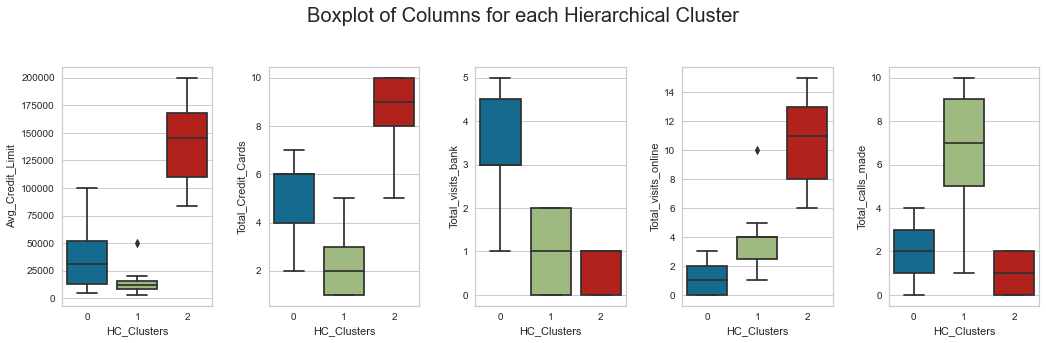

In [61]:
fig, axes = plt.subplots(1, 5, figsize=(15, 5)) # Define the size and layout of the plot
fig.suptitle('Boxplot of Columns for each Hierarchical Cluster', fontsize=20)
counter = 0
for ii in range(5): # Define a function to create a boxplot for each feature in the scaled df
    sns.boxplot(ax=axes[ii],y=df[cols[counter]],x=df['HC_Clusters'])
    counter = counter+1

fig.tight_layout(pad=2.0)

#### Observations
* The count in each segment is almost identical. K-Means has 1 more customer in cluster 0 than Hierarchical, while Hierarchical has 1 more customer in cluster 1 than K-Means. 
* The average values in cluster 2 are identical, indicating the cluster 2 has the same customers through both methods. 
* The average values are almost identical between cluster 0 and cluster 1 in both methods, indicating that the customers are likely the same through both methods (except 1 customer who was segmented differently)

<a href = #TOC>Back to Top</a>

# <a id = "conclusion"></a>7. Conculsion and Business Recommendations

## Analysis of the Clusters Formed

## Cluster Insights:
**Cluster 0: In-Person Customers**
* This is the largest cluster with 379 customers. 
* Most customers have an average credit limit between 15,000 and 50,000, and all have an average limit of 100,000 or less
* These customers have 2 to 7 credit cards, with most having 4 to 6.
* These cusomters visit the bank in person much more often than other segments. The visit 2 to 5 times, with most visiting 3 to 4 times
* These customers are not heavy online users -- most have visited the online site 0 to 2 times
* These customers call fairly infrequently -- 1 to 3 times
* Overall, I would call this segment the "In-Person Customers" because their differentiating trait is that they tend to visit in-person much more often than the other two clusters. Because of their preference for in-person visits, they don't use the online site hardly at all and they don't call very often. 

**Cluster 1: Phone Customers**
* This is the middle-sized cluster with 223 customers. 
* These customers have by far the lowest average credit limit -- almost all are under 25,000, with most around 15,000. 
* These customers also have the fewest credit cards -- all with 4 or fewer. Most have 1 to 3 credit cards. 
* These customers do not visit the bank in-person very often -- all visit 0 to 2 times
* These customers use the online site some, but still not often. Most use the online site 3 to 4 times
* These customers have a strong preference for the phone. They call more often than the other clusters. 50% call 5 to 9 times. The next highest segment has a max of 4 calls. 
* Overall, I would call this segment the "Phone Customers" because of their strong preference for phone-based interaction. It is their differentiating factor, though they are also unique in having lower credit limits and fewer credit cards. 

**Cluster 2: Online Customers**
* This is the smallest cluster with only 48 customers. 
* These customers have much higher average credit limits, ranging from 80,000 to 200,000. 50% have avg credit limits between 110,000 and 160,000 while the next highest segment has a max avg credit limit of 100,000. 
* These customers also have a lot more credit cards -- 50 % of them have 8 to 10 cards while the next highest segment averages 4 to 6
* These customers rarely visit the bank in person. None of them has visited more than once. 
* These customers use the online channel frequently -- 50% have 8 to 13 online visits while the next highest segment averages 3 to 4. 
* These customers also don't like to call -- none has called more than twice. 

## Key Questions

### 1. How many different segments of customers are there?

There appear to be 3 distinct segments based primarily on how the customer prefers to interact with the bank: In-Person, Phone, or Online. 

### 2. How are these segments different from each other?

See detailed analysis above. In summary:
* **In-Person** segment customers visit the bank 3 or more times in the period (monthly? frequency is not defined in the data dictionary). They tend to have mid-range credit limits and mid-range number of credit cards. They are the largest group of customers. They do not like to use our online services and do not call very often. 
* **Phone** segment customers Don't visit in person very often or use our online services very often, but they do call frequently -- nearly 7 times on average. This is the second largest group of customers. They are our lowest value segment because they have the lowest average credit limit and fewest credit cards. 
* **Online** segment customers rarely visit in person or call. Instead they prefer to use our online services -- almost 11 times on average. They are by far our smallest group of customers, but also our highest value customers because they have much higher average credit limits and more credit cards. 

### 3. What are your recommendations to the bank on how to better market to and service these customers?

We have a big opportunity because our smallest group of customers are our highest value customers (higher cerdit limits and more cards typically mean more usage which means more fees and other forms of revenue). So, with intentonal effort, we can gain and retain more Online segment customer who have a higher per-customer revenue. 

We have limited information in this case study, so I would definitely want to ask additional questions of the business and look at other data to more fully understand the context. However, with some assumptions, I would make these recommendations to the bank to better market and service these customers: 
* Reduce spending on our phone services/teams and reallocate those resources towards improving our online service. People who call generate the lowest per-customer revenue, so our money is better spent attracting and retaining online customers. 
* We should continue to invest in our in-person experience at the bank as the group that prefers this mode of interaction is our largest and has medium per-customer value, too. 
* We should target campaigns at the In-Person segment to encourage them to use our online services. We should provide education and resources to make it easier for them to learn how to use our online platform. We should do user research and spend resources to improve our online experience so that more In-Person customers will use it. 
* We should do additional demographic research on our Online customer segment to better understand who they are. We should use that information to identify what drew them to our bank and then market to similar people who are not currently customers. 

<a href = #TOC>Back to Top</a>